<a href="https://colab.research.google.com/github/diegop2110/Talento_Tech/blob/main/Proyecto_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Proyecto de Clasificación de Imágenes de Flores Utilizando Redes Neuronales
El objetivo de este proyecto es comparar el rendimiento de diferentes modelos de redes neuronales en la tarea de clasificación de imágenes de flores. Utilizamos tres modelos: una CNN simple, EfficientNet-B0 y MobileNetV3. El dataset utilizado es el de "tf_flowers" proporcionado por TensorFlow Datasets.

Cargar y Preprocesar el Dataset:

Utilizamos el dataset "tf_flowers" de TensorFlow Datasets.
Dividimos el dataset en conjuntos de entrenamiento (80%) y validación (20%).
Preprocesamos las imágenes, redimensionándolas a 224x224 píxeles y normalizándolas (escalando los valores de los píxeles entre 0 y 1).

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds

# Descargar el dataset de flores
(dataset_train, dataset_val), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

# Función para preprocesar las imágenes
def format_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0
    return image, label

# Aplicar preprocesamiento
batch_size = 32
train_batches = dataset_train.map(format_image).shuffle(1000).batch(batch_size).prefetch(1)
val_batches = dataset_val.map(format_image).batch(batch_size).prefetch(1)


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


#Definir los Modelos:

##Modelo CNN Simple:
Construimos una red neuronal convolucional simple con capas de convolución, max-pooling, flatten, dense y dropout.

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_simple_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (224, 224, 3)
num_classes = dataset_info.features['label'].num_classes
simple_cnn = create_simple_cnn(input_shape, num_classes)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
history_simple_cnn = simple_cnn.fit(train_batches,
                                    validation_data=val_batches,
                                    epochs=15)



Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 318s 3s/step - accuracy: 0.2868 - loss: 2.6880 - val_accuracy: 0.5027 - val_loss: 1.2529
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.4943 - loss: 1.2220 - val_accuracy: 0.5967 - val_loss: 1.0828
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - accuracy: 0.6555 - loss: 0.9562 - val_accuracy: 0.6076 - val_loss: 1.0160
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 308s 3s/step - accuracy: 0.7816 - loss: 0.6212 - val_accuracy: 0.6226 - val_loss: 1.0493
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 318s 3s/step - accuracy: 0.8764 - loss: 0.4022 - val_accuracy: 0.6076 - val_loss: 1.1777
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 304s 3s/step - accuracy: 0.9106 - loss: 0.2808 - val_accuracy: 0.5831 - val_loss: 1.4043
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 314s 3s/step - accuracy: 0.9515 - loss: 0.1981 - val_accuracy: 0.5872 - val_loss: 1.4357
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 340s 4s/step - accuracy: 0.9594 - loss: 0.1264 - val_accuracy: 0.5232 - v

734/734 ━━━━━━━━━━━━━━━━━━━━ 30s 41ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


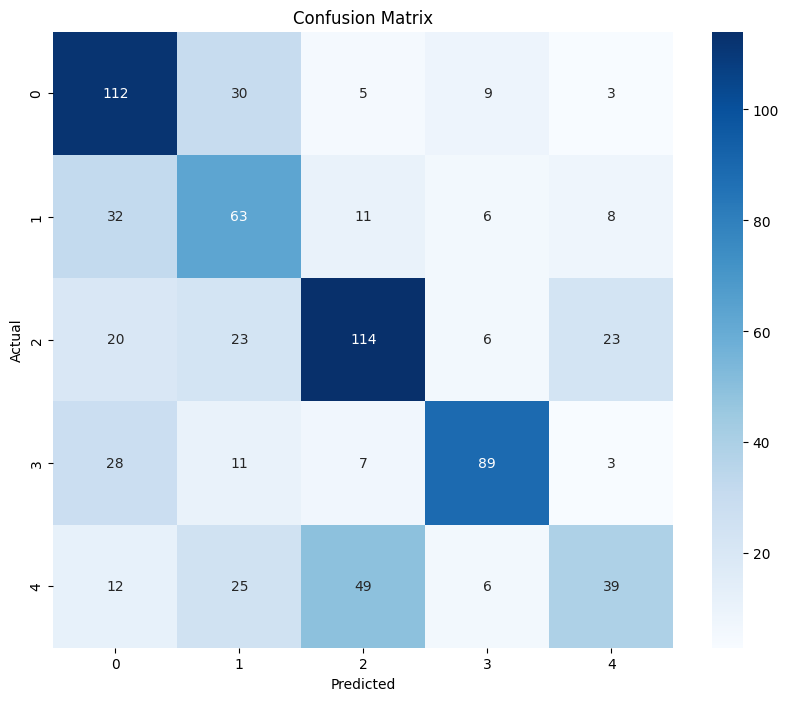

              precision    recall  f1-score   support

   dandelion       0.55      0.70      0.62       159
       daisy       0.41      0.53      0.46       120
      tulips       0.61      0.61      0.61       186
  sunflowers       0.77      0.64      0.70       138
       roses       0.51      0.30      0.38       131

    accuracy                           0.57       734
   macro avg       0.57      0.56      0.55       734
weighted avg       0.58      0.57      0.56       734



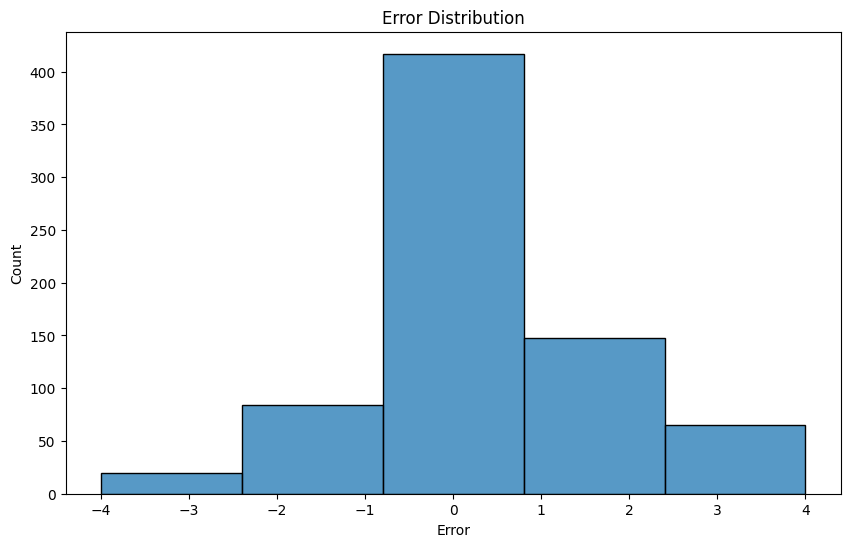

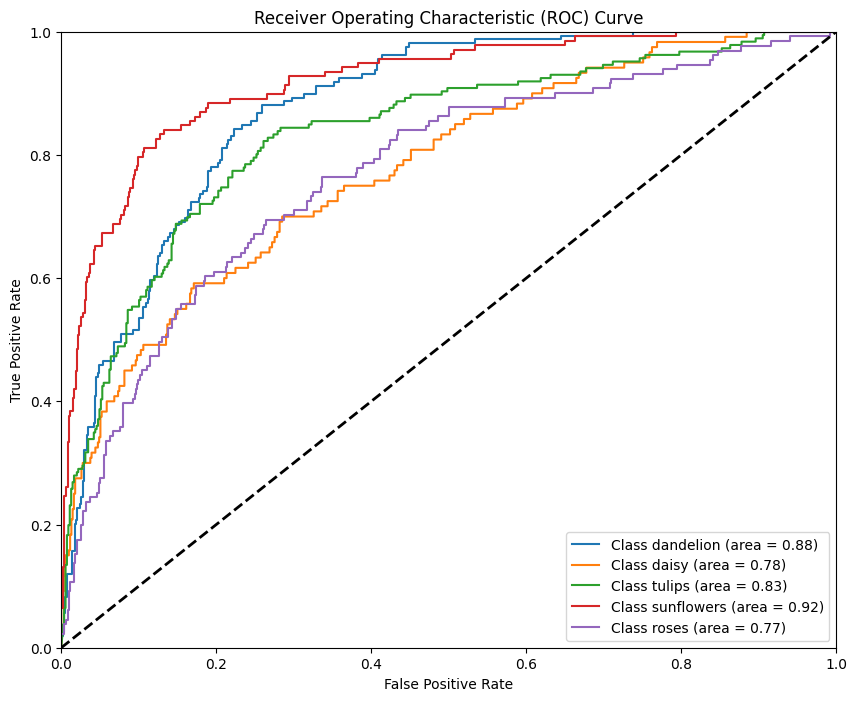

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize

def evaluate_cnn_model(model, val_batches, class_names):
    # Preparar los datos
    val_batches = val_batches.unbatch().batch(1)
    y_true = np.concatenate([y for x, y in val_batches], axis=0)
    y_pred_prob = model.predict(val_batches)
    y_pred = np.argmax(y_pred_prob, axis=-1)

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Informe de clasificación
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Distribución de errores
    errors = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, bins=len(class_names), kde=False)
    plt.xlabel('Error')
    plt.ylabel('Count')
    plt.title('Error Distribution')
    plt.show()

    # Curva ROC
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_names[i]} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Evaluar el modelo CNN simple
class_names = dataset_info.features['label'].names
evaluate_cnn_model(simple_cnn, val_batches, class_names)


##Modelo EfficientNet-B0:
Utilizamos EfficientNet-B0 preentrenado en ImageNet, congelamos sus capas y añadimos una capa de global average pooling y capas densas para la clasificación.

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

def create_efficientnet_b0(input_shape, num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

efficientnet_b0 = create_efficientnet_b0(input_shape, num_classes)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


##Modelo MobileNetV3:
 Utilizamos MobileNetV3 preentrenado en ImageNet, congelamos sus capas y añadimos una capa de global average pooling y capas densas para la clasificación.

In [ ]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

def create_mobilenet_v3(input_shape, num_classes):
    base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

mobilenet_v3 = create_mobilenet_v3(input_shape, num_classes)


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


##Entrenar los Modelos:


Entrenamos cada uno de los modelos con los datos preprocesados durante un máximo de 15 épocas.

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [ ]:
history_efficientnet_b0 = efficientnet_b0.fit(train_batches,
                                              validation_data=val_batches,
                                              epochs=20)



Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 337s 4s/step - accuracy: 0.2195 - loss: 1.6132 - val_accuracy: 0.2166 - val_loss: 1.6092
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 349s 3s/step - accuracy: 0.2594 - loss: 1.6016 - val_accuracy: 0.2166 - val_loss: 1.6061
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 318s 3s/step - accuracy: 0.2546 - loss: 1.6026 - val_accuracy: 0.2166 - val_loss: 1.6040
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 347s 3s/step - accuracy: 0.2544 - loss: 1.5992 - val_accuracy: 0.2166 - val_loss: 1.6062
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 302s 3s/step - accuracy: 0.2420 - loss: 1.6051 - val_accuracy: 0.2166 - val_loss: 1.6048
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 330s 3s/step - accuracy: 0.2591 - loss: 1.5963 - val_accuracy: 0.2166 - val_loss: 1.6042
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 316s 3s/step - accuracy: 0.2611 - loss: 1.5991 - val_accuracy: 0.2166 - val_loss: 1.6043
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 301s 3s/step - accuracy: 0.2554 - loss: 1.6008 - val_accuracy: 0.2166 - v

In [ ]:
history_mobilenet_v3 = mobilenet_v3.fit(train_batches,
                                        validation_data=val_batches,
                                        epochs=20)



Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 56s 510ms/step - accuracy: 0.2417 - loss: 1.6315 - val_accuracy: 0.2180 - val_loss: 1.5967
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 77s 469ms/step - accuracy: 0.2563 - loss: 1.5954 - val_accuracy: 0.2398 - val_loss: 1.5889
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 45s 477ms/step - accuracy: 0.2708 - loss: 1.5900 - val_accuracy: 0.3093 - val_loss: 1.5775
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 46s 489ms/step - accuracy: 0.2999 - loss: 1.5790 - val_accuracy: 0.2970 - val_loss: 1.5713
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 45s 483ms/step - accuracy: 0.2886 - loss: 1.5832 - val_accuracy: 0.2847 - val_loss: 1.5714
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 81s 474ms/step - accuracy: 0.2839 - loss: 1.5778 - val_accuracy: 0.2807 - val_loss: 1.5750
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 44s 476ms/step - accuracy: 0.2811 - loss: 1.5718 - val_accuracy: 0.3011 - val_loss: 1.5504
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 502ms/step - accuracy: 0.2801 - loss: 1.5652 - val_accu

##Evaluar los Modelos:

Utilizamos los datos de validación para hacer predicciones con cada modelo.
Calculamos y mostramos la matriz de confusión para visualizar los errores de clasificación.
Generamos un informe de clasificación que incluye métricas como precisión, recall y F1-score para cada clase.

734/734 ━━━━━━━━━━━━━━━━━━━━ 28s 38ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


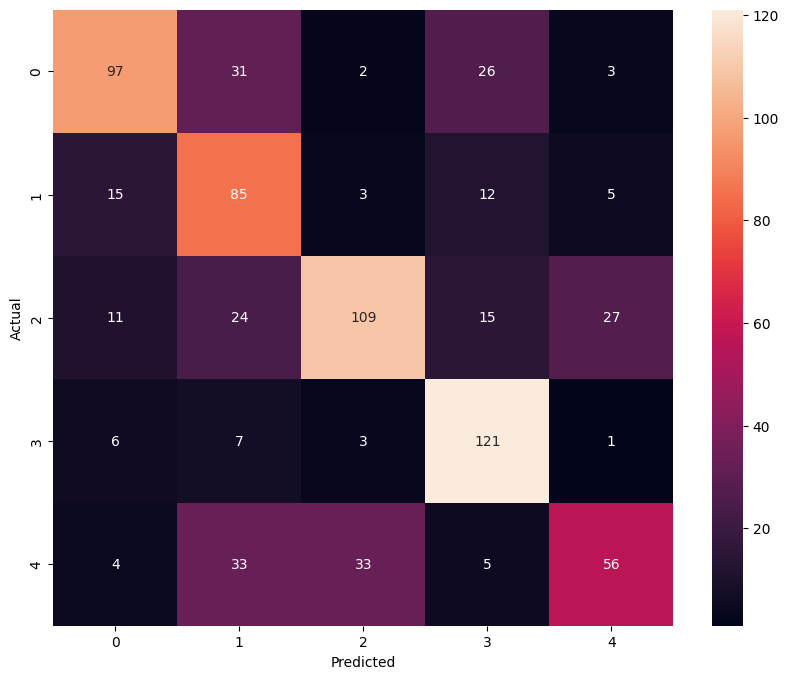

              precision    recall  f1-score   support

   dandelion       0.73      0.61      0.66       159
       daisy       0.47      0.71      0.57       120
      tulips       0.73      0.59      0.65       186
  sunflowers       0.68      0.88      0.76       138
       roses       0.61      0.43      0.50       131

    accuracy                           0.64       734
   macro avg       0.64      0.64      0.63       734
weighted avg       0.66      0.64      0.63       734

734/734 ━━━━━━━━━━━━━━━━━━━━ 58s 76ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


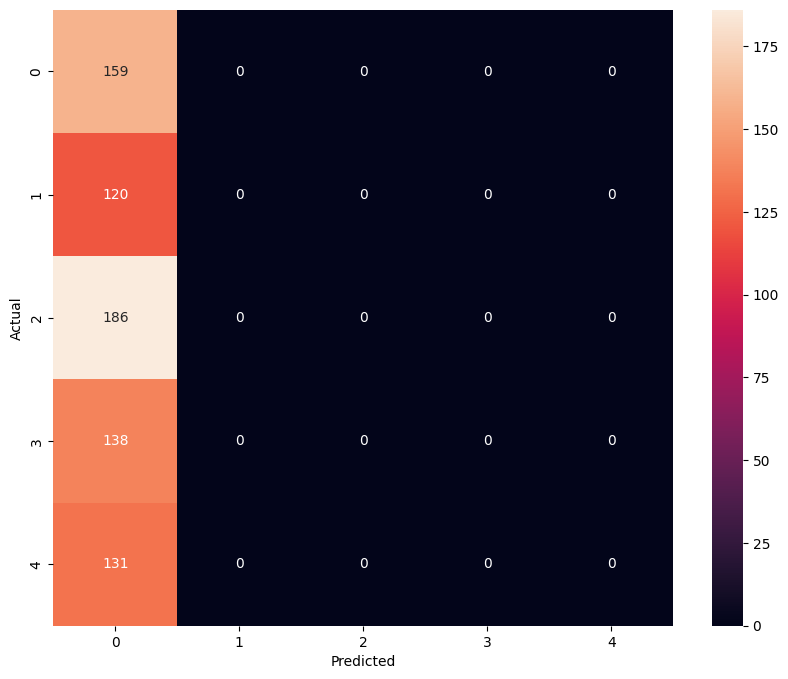

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

   dandelion       0.22      1.00      0.36       159
       daisy       0.00      0.00      0.00       120
      tulips       0.00      0.00      0.00       186
  sunflowers       0.00      0.00      0.00       138
       roses       0.00      0.00      0.00       131

    accuracy                           0.22       734
   macro avg       0.04      0.20      0.07       734
weighted avg       0.05      0.22      0.08       734

734/734 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


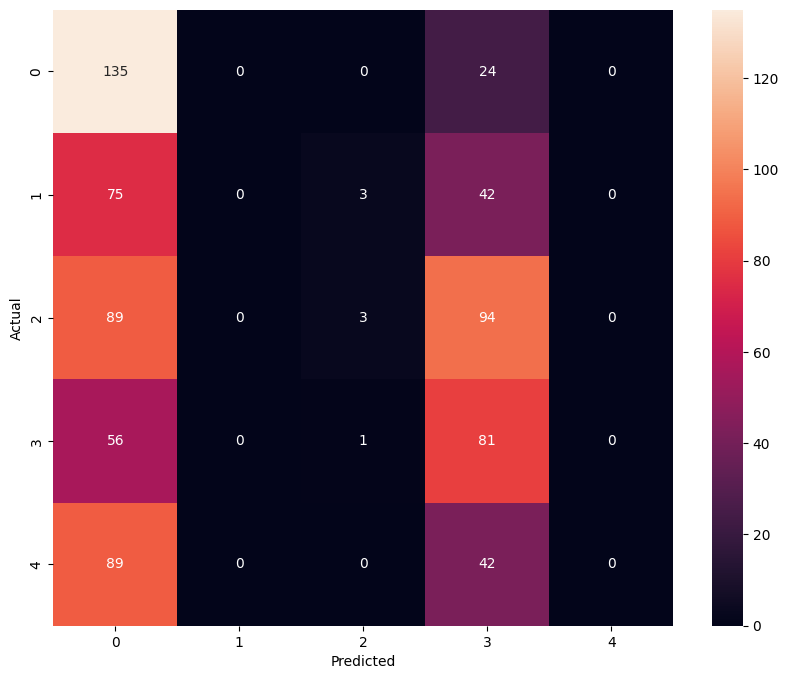

              precision    recall  f1-score   support

   dandelion       0.30      0.85      0.45       159
       daisy       0.00      0.00      0.00       120
      tulips       0.43      0.02      0.03       186
  sunflowers       0.29      0.59      0.38       138
       roses       0.00      0.00      0.00       131

    accuracy                           0.30       734
   macro avg       0.20      0.29      0.17       734
weighted avg       0.23      0.30      0.18       734



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, val_batches):
    val_batches = val_batches.unbatch().batch(1)
    y_true = np.concatenate([y for x, y in val_batches], axis=0)
    y_pred = np.argmax(model.predict(val_batches), axis=-1)

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Informe de clasificación
    print(classification_report(y_true, y_pred, target_names=dataset_info.features['label'].names))

# Evaluar el modelo CNN simple
evaluate_model(simple_cnn, val_batches)

# Evaluar el modelo EfficientNet-B0
evaluate_model(efficientnet_b0, val_batches)

# Evaluar el modelo MobileNetV3
evaluate_model(mobilenet_v3, val_batches)


##Visualizar la Historia de Entrenamiento:

Graficamos la precisión y la pérdida durante el entrenamiento para ambos conjuntos, entrenamiento y validación, para cada modelo. Esto nos permite visualizar cómo de bien está aprendiendo cada modelo y si hay problemas como el sobreajuste.

734/734 ━━━━━━━━━━━━━━━━━━━━ 30s 41ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


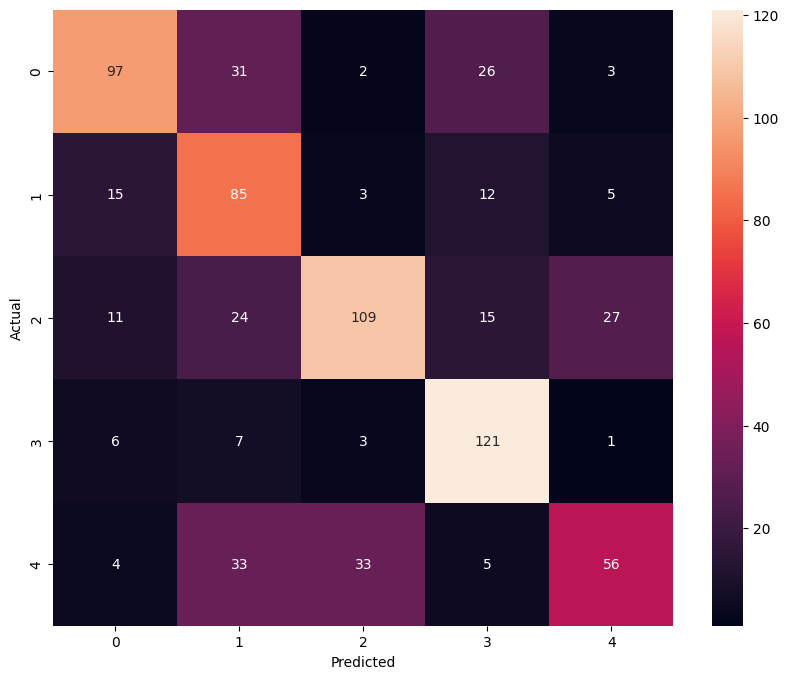

              precision    recall  f1-score   support

   dandelion       0.73      0.61      0.66       159
       daisy       0.47      0.71      0.57       120
      tulips       0.73      0.59      0.65       186
  sunflowers       0.68      0.88      0.76       138
       roses       0.61      0.43      0.50       131

    accuracy                           0.64       734
   macro avg       0.64      0.64      0.63       734
weighted avg       0.66      0.64      0.63       734

734/734 ━━━━━━━━━━━━━━━━━━━━ 58s 79ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


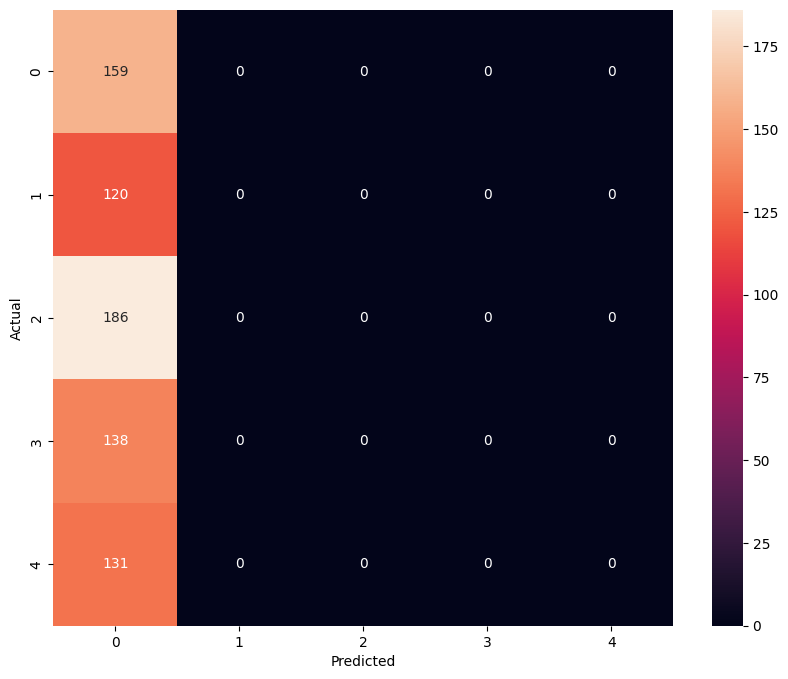

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

   dandelion       0.22      1.00      0.36       159
       daisy       0.00      0.00      0.00       120
      tulips       0.00      0.00      0.00       186
  sunflowers       0.00      0.00      0.00       138
       roses       0.00      0.00      0.00       131

    accuracy                           0.22       734
   macro avg       0.04      0.20      0.07       734
weighted avg       0.05      0.22      0.08       734

734/734 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


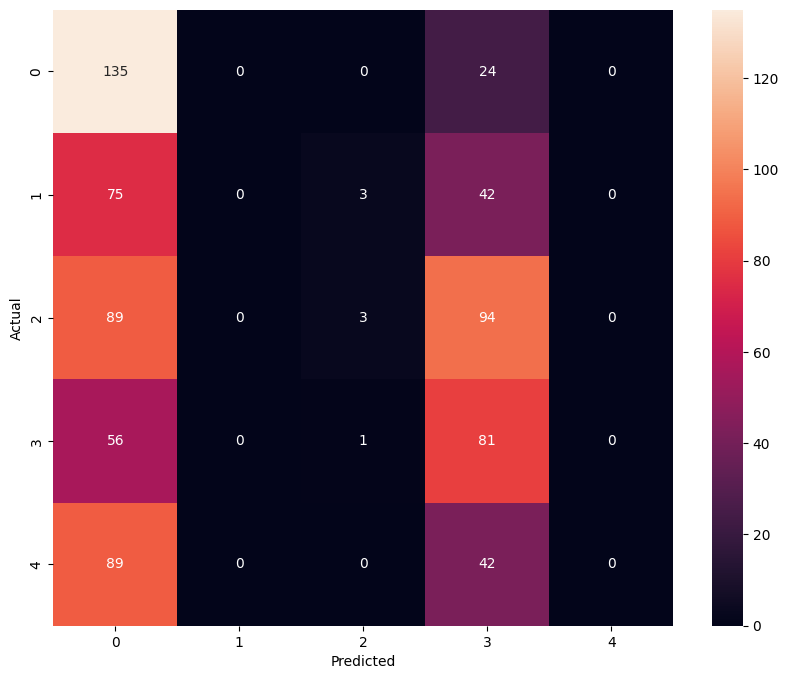

              precision    recall  f1-score   support

   dandelion       0.30      0.85      0.45       159
       daisy       0.00      0.00      0.00       120
      tulips       0.43      0.02      0.03       186
  sunflowers       0.29      0.59      0.38       138
       roses       0.00      0.00      0.00       131

    accuracy                           0.30       734
   macro avg       0.20      0.29      0.17       734
weighted avg       0.23      0.30      0.18       734



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, val_batches):
    val_batches = val_batches.unbatch().batch(1)
    y_true = np.concatenate([y for x, y in val_batches], axis=0)
    y_pred = np.argmax(model.predict(val_batches), axis=-1)

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Informe de clasificación
    print(classification_report(y_true, y_pred, target_names=dataset_info.features['label'].names))

# Evaluar el modelo CNN simple
evaluate_model(simple_cnn, val_batches)

# Evaluar el modelo EfficientNet-B0
evaluate_model(efficientnet_b0, val_batches)

# Evaluar el modelo MobileNetV3
evaluate_model(mobilenet_v3, val_batches)
